In [31]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_validate

from src.data.dataloader_functions import *
from src.utils.results_utils import *
from src.utils.recovery_analysis_utils import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Make the code reproducible
SEED = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [32]:
df_all_declines_original = pd.read_csv('data/decline_events_complete.csv')
df_channels = pd.read_csv('data/df_channels_en.tsv', sep='\t', usecols=['channel', 'category_cc'], index_col='channel')
df_data_processed = load_processed_data(usecols=['channel', 'week', 'subs', 'activity', 'views'])

# Finding the outcome

Using the duration of the decline, determine whether the YouTuber recovered or not.

In [33]:
df_all_declines = df_all_declines_original.copy()

# If the decline is longer than 4 months without recovery, we consider the YouTuber was not successful in handling it.
# Our aim is to find strategies that lead to quick recoveries, therefore taking more than 4 months would be considered unsuccessful.
RECOVERY_THRESHOLD = 4 * 4

# Add the decline outcome
df_all_declines['Recovered'] = df_all_declines['Duration'] < RECOVERY_THRESHOLD

# Split the tuple (decline start, decline end) into two separate columns
df_all_declines['Event'] = df_all_declines['Event'].apply(lambda s: [int(week_id) for week_id in s[1:-1].split(', ')])
df_all_declines['Start'] = df_all_declines['Event'].apply(lambda e: e[0])
df_all_declines['End'] = df_all_declines['Event'].apply(lambda e: e[1])
df_all_declines.drop('Event', axis=1, inplace=True)

# Add the channel category
df_all_declines['Category'] = df_all_declines['Channel'].apply(lambda c: df_channels.loc[c]['category_cc'])

# Add the channel's subs at the start of the decline
decline_index = list(zip(df_all_declines['Channel'], df_all_declines['Start']))
df_all_declines['Subs_start'] = df_data_processed.loc[decline_index, 'subs'].values

# Add the activity at the start of the decline
df_all_declines['Activity_start'] = df_data_processed.loc[decline_index, 'activity'].values

# Add the channel's subs at the start of the decline
df_all_declines['Views_start'] = df_data_processed.loc[decline_index, 'views'].values

print(f"Overall recovery rate: {df_all_declines['Recovered'].mean():.2f}")

df_all_declines.head()

Overall recovery rate: 0.46


,Channel,Duration,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start
0,UCi8IX8CVCHRKiLV_eCWEKNA,20,False,117,137,People & Blogs,32974.875000,1,1.842075e+06
1,UCi8IX8CVCHRKiLV_eCWEKNA,28,False,190,218,People & Blogs,150182.875000,3,1.236850e+07
2,UCW4jUKddkdTJwl3EFlc8ZMQ,13,True,218,231,Film and Animation,12939.125000,0,4.470020e+06
3,UC_hZX0wqyjq3CabYF25ol8Q,18,False,224,242,Gaming,16797.444444,4,5.939868e+06
4,UC-TDzpXxJndgBvyX4dZXVzA,29,False,172,201,Music,22794.200000,0,3.953500e+06


# How is the recovery distributed?

To get a first idea of what factors come into play when a YouTuber tries to recover from a decline, we plot some distributions.

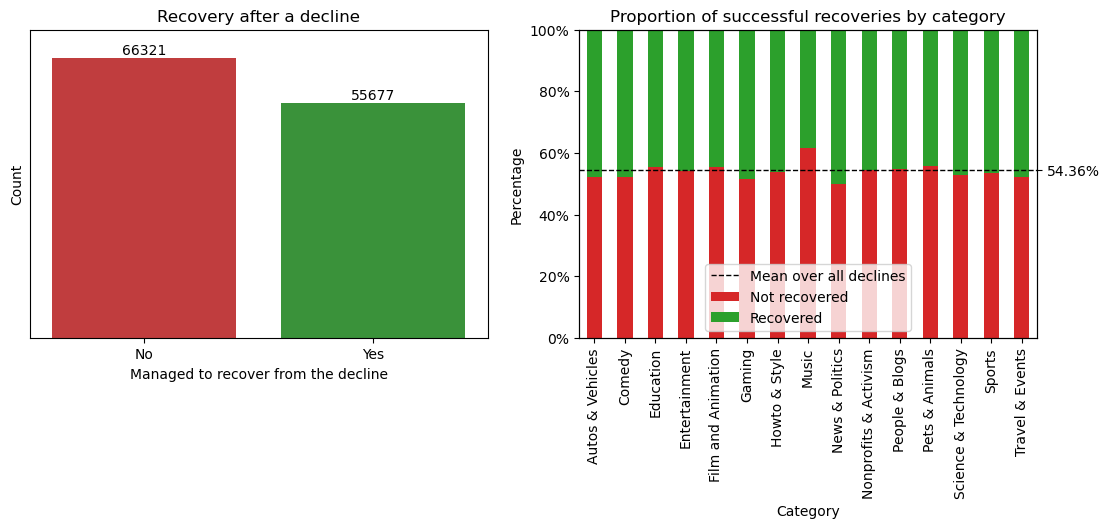

In [34]:
plot_recovered_by_categories(df_all_declines)

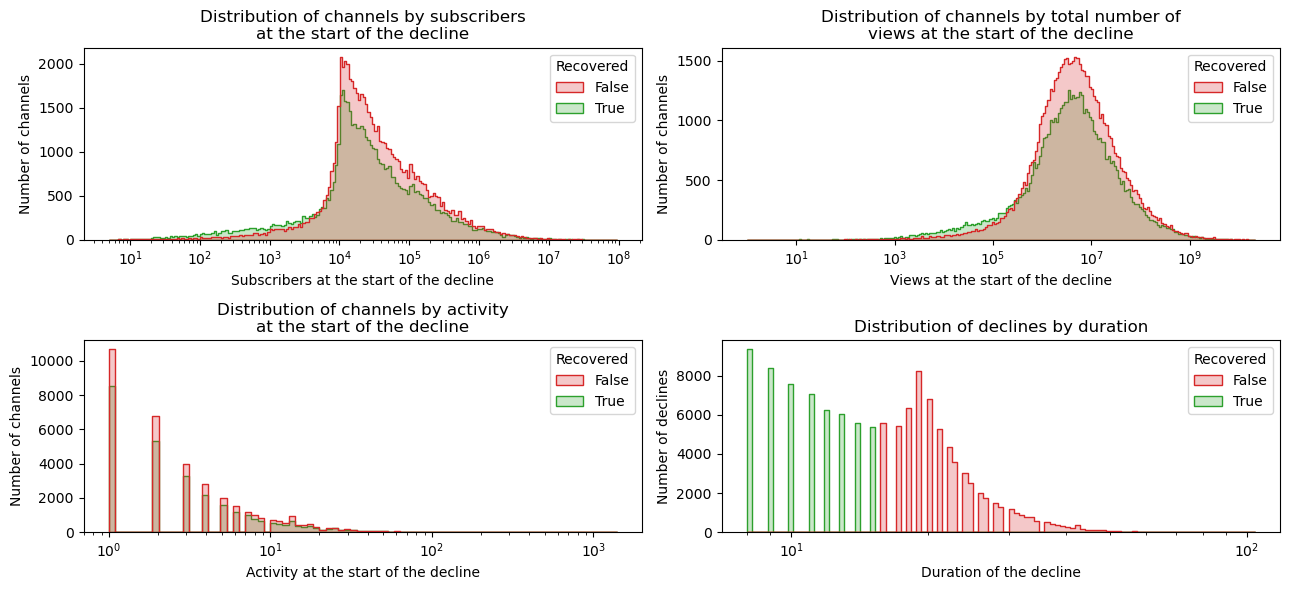

In [35]:
plot_group_distributions(df_all_declines)

We can observe that some features are not balanced between the declines that recovered and those that did not, especially views and subscribers at the start of the decline.

In [36]:
print(df_all_declines['Recovered'].value_counts())
print(f"\nTotal number of declines: {len(df_all_declines)}")

Recovered
False    66321
True     55677
Name: count, dtype: int64

Total number of declines: 121998


# YouTuber reactions

Aiming at finding the best ways to deal with a decline depending on the situation, we take a look at how the YouTubers reacted to the decline, and what methods proved effective.\
In order to observe the reaction's impact, we will conduct a matched observational study on the dataset by using propensity score matching.

Considering the size of the dataset, we use random sampling to ease the matching's computation.\
To check that sampling does not mess with the distribution of recoveries, we plot them depending on the sampling proportion.

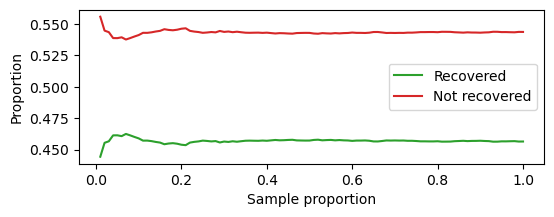

In [37]:
plot_sampling_rates(df_all_declines, SEED)

We choose to sample 30% of the data since it considerably reduces the size of the dataset, and allows to keep a representative sample of the data without perturbing the recovery distribution.

In [38]:
df_sampled = df_all_declines.sample(frac=0.3, replace=False, random_state=SEED)

print(df_sampled['Recovered'].value_counts())
print(f"\nTotal number of declines after sampling: {len(df_sampled)}")

Recovered
False    19897
True     16702
Name: count, dtype: int64

Total number of declines after sampling: 36599


### Adding the reaction metrics whose impact we want to measure

The reactions that we are able to observe here are the following:
- Did the YouTuber change video publication frequency?
- Did the YouTuber change video length?
- Did the YouTuber change video category?

In [39]:
# Load the videos around the declines, from week (decline start - decline duration) to week (decline end)
videos_around_declines = pd.read_csv('data/videos_around_declines.csv')

# Add the declines with the indices of the corresponding videos
df_sampled = get_sampled_declines_with_videos(df_sampled, videos_around_declines)

# Augment the data with the video stats : videos per week and mean video duration, before and during the declines
df_sampled = add_video_stats(df_sampled, videos_around_declines)

DIV_BY_ZERO_TOLERANCE = 1e-6

# Indicate whether the channel increased mean video duration after the start of the decline. We include a tolerance of 50% change.
df_sampled['Mean_duration_difference'] = df_sampled.apply(lambda row: row['Mean_duration_after'] - row['Mean_duration_before'], axis=1)
df_sampled['Posted_longer_videos'] = df_sampled.apply(lambda row: (row['Mean_duration_difference']) / np.max([row['Mean_duration_before'], DIV_BY_ZERO_TOLERANCE]) > 0.5, axis=1)
df_sampled['Posted_shorter_videos'] = df_sampled.apply(lambda row: (row['Mean_duration_difference']) / np.max([row['Mean_duration_before'], DIV_BY_ZERO_TOLERANCE]) < -0.5, axis=1)
print(f"\n{df_sampled['Posted_longer_videos'].mean() * 100:.2f}% of the channels posted longer videos after the start of the decline.")
print(f"{df_sampled['Posted_shorter_videos'].mean() * 100:.2f}% of the channels posted shorter videos after the start of the decline.\n")

# Indicate whether the channel changed publishing frequency after the start of the decline. We include a tolerance of 100% change (doubling the frequency).
df_sampled['Mean_frequency_difference'] = df_sampled.apply(lambda row: row['Videos_per_week_after'] - row['Videos_per_week_before'], axis=1)
df_sampled['Posted_more'] = df_sampled.apply(lambda row: (row['Mean_frequency_difference']) / np.max([row['Videos_per_week_before'], DIV_BY_ZERO_TOLERANCE]) > 0.5, axis=1)
df_sampled['Posted_less'] = df_sampled.apply(lambda row: (row['Mean_frequency_difference']) / np.max([row['Videos_per_week_before'], DIV_BY_ZERO_TOLERANCE]) < -0.5, axis=1)
print(f"{df_sampled['Posted_more'].mean() * 100:.2f}% of the channels posted more videos after the start of the decline.")
print(f"{df_sampled['Posted_less'].mean() * 100:.2f}% of the channels posted less videos after the start of the decline.")

# Drop the declines with missing data (usually due to having no video before or after the decline, or no category)
df_sampled = df_sampled.dropna()

# Put the differences aside, to be used later but not in the models
df_videos_per_week = df_sampled[['Videos_per_week_before', 'Videos_per_week_after']]
df_video_duration = df_sampled[['Mean_duration_before', 'Mean_duration_after']] 
df_sampled = df_sampled.drop(['Mean_duration_before', 'Mean_duration_after'], axis=1)
df_sampled = df_sampled.drop(['Videos_per_week_before', 'Videos_per_week_after'], axis=1)

# Keep a copy of the declines that have videos before and after the decline
df_sampled_without_zero_videos = df_sampled[(df_sampled['Videos_before'].apply(len) > 0) & (df_sampled['Videos_after'].apply(len) > 0)]

# Drop the indices of the videos, they are not needed anymore
df_sampled = df_sampled.drop(['Videos_before', 'Videos_after'], axis=1)
df_sampled_without_zero_videos = df_sampled_without_zero_videos.drop(['Videos_before', 'Videos_after'], axis=1)

df_sampled.head()

Sampled declines with videos loaded from file.

12.08% of the channels posted longer videos after the start of the decline.
6.52% of the channels posted shorter videos after the start of the decline.

22.65% of the channels posted more videos after the start of the decline.
24.69% of the channels posted less videos after the start of the decline.


,Channel,Duration,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start,Mean_duration_difference,Posted_longer_videos,Posted_shorter_videos,Mean_frequency_difference,Posted_more,Posted_less
0,UC3B6FyoLMLrUYa6i72ccPvw,20,False,189,209,Howto & Style,271299.750000,3,1.753062e+07,419.748120,True,False,-0.250000,False,False
1,UCIHBFO-XMyTpzXAN-lg8o2g,14,True,112,126,Gaming,135126.510417,1,2.758465e+07,1432.453191,True,False,-1.214286,False,False
2,UCWmJyyUVP6AoR79IA9MTNpQ,30,False,192,222,People & Blogs,14676.662037,0,5.199927e+06,-7.000000,False,False,0.000000,False,False
3,UC2MjZanWOfyfsrHOyitmXbQ,14,True,128,142,Gaming,53787.000000,5,3.935174e+06,-177.302463,False,False,0.428571,False,False
4,UCgUtduvq2Wpc7CDHcGDmZog,15,True,188,203,Pets & Animals,12262.312500,7,2.818956e+06,-249.533333,False,False,-0.600000,False,False


### Propensity score matching

Seeing that the declines do not have the same distribution on their features, we perform propensity score matchings to balance the treatment and control groups looking at the effect that changing publication frequency,video duration and video category after the start of the decline have on the recovery.

After the propensity score matching, we can observe the effect of the different treatments on the recovery :

Matches loaded from file for treatment Posted_more.
Posted_more matches : [(33079, 5), (20338, 9), (11536, 12), (26427, 14), (22389, 18), (14948, 25), (10577, 37), (27983, 42), (12882, 43), (16322, 47), (21514, 52), (34946, 59), (24847, 63), (30956, 65), (34247, 68), (3887, 78), (4098, 92), (12101, 96), (8780, 98), (21336, 107), (28343, 109), (34293, 110), (1200, 111), (8579, 121), (28626, 125), (9718, 136), (27279, 140), (24835, 141), (34262, 143), (5003, 160), (33519, 165), (20930, 179), (22329, 180), (28188, 195), (19485, 206), (36556, 210), (10019, 215), (2, 218), (12541, 225), (30456, 229), (465, 236), (1612, 237), (32103, 245), (12363, 248), (13354, 251), (35462, 268), (33753, 272), (19558, 276), (20484, 279), (30269, 283), (10131, 286), (19680, 287), (19159, 308), (24027, 311), (6975, 314), (19951, 316), (6822, 323), (2890, 328), (19042, 329), (5234, 330), (9764, 334), (21824, 338), (35192, 341), (486, 349), (14308, 356), (14926, 361), (14764, 363), (31877, 371), (28466, 376), (

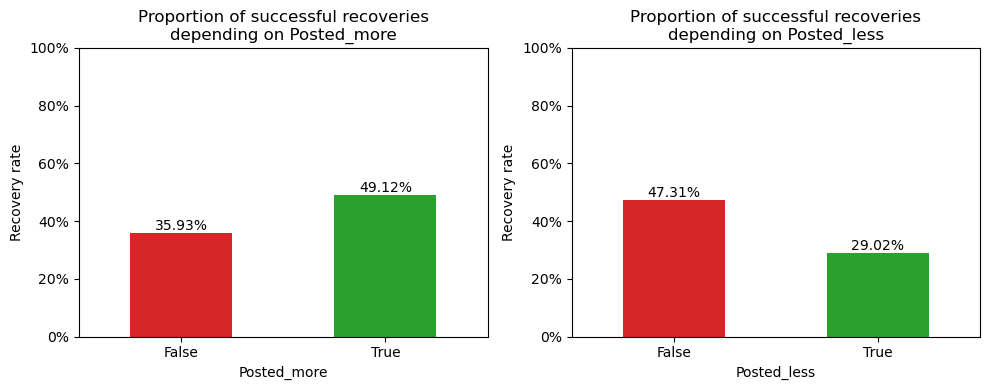

Matches loaded from file for treatment Posted_longer_videos.
Posted_longer_videos matches : [(1632, 0), (25621, 1), (33567, 15), (20935, 21), (543, 34), (32549, 39), (26502, 74), (5916, 75), (22737, 90), (35691, 94), (27840, 100), (32610, 117), (3035, 118), (18912, 133), (8390, 141), (15239, 150), (28737, 151), (19552, 159), (20272, 164), (11380, 165), (5483, 166), (2132, 169), (6204, 180), (14869, 184), (6289, 221), (35391, 233), (29984, 235), (3979, 240), (27389, 248), (17665, 252), (15951, 266), (12885, 274), (22826, 276), (190, 286), (1817, 288), (14432, 295), (9718, 305), (6824, 310), (30061, 313), (30273, 323), (27897, 332), (7351, 346), (12374, 348), (24057, 351), (20488, 352), (1172, 371), (546, 373), (8941, 375), (2327, 378), (27741, 384), (25193, 389), (21331, 394), (17966, 396), (5641, 400), (11466, 401), (6712, 404), (1414, 409), (16957, 430), (33519, 431), (6486, 433), (23879, 438), (11074, 439), (30968, 440), (31496, 468), (31181, 471), (8130, 476), (15761, 485), (17450, 

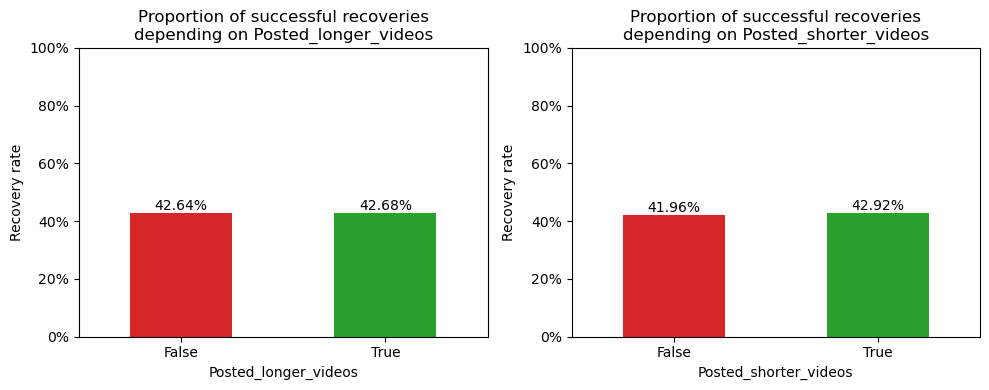

In [40]:
# The variables to be used for the matching
# Treatments in the same array will be plotted together
TREATMENTS = [
    ['Posted_more',
    'Posted_less'],
    ['Posted_longer_videos',
    'Posted_shorter_videos']
]

# The variables to be dropped for each treatment (to avoid multicollinearity or strong correlation)
# Use the same order as the TREATMENTS array
to_drop = [
    [['Mean_frequency_difference', 'Posted_less'],
    ['Mean_frequency_difference', 'Posted_more']],
    [['Mean_duration_difference', 'Posted_shorter_videos'],
    ['Mean_duration_difference', 'Posted_longer_videos']]
]

matched_dfs = {}
for plot_treatments, plot_dropped in zip(TREATMENTS, to_drop):
    fig, axes = plt.subplots(1, len(plot_treatments), figsize=(5*len(plot_treatments), 4))
    for subplot_id, (treatment, dropped) in enumerate(zip(plot_treatments, plot_dropped)):

        # Try to load the matches from the file, otherwise compute them
        matches = get_matches(treatment=treatment, declines=df_sampled.drop(dropped, axis=1), verbose=False)

        print(f"{treatment} matches :", matches)

        # Flatten
        matches = [index for match in matches for index in match]

        # Get the matched declines
        matched_dfs[treatment] = df_sampled.loc[matches]

        plot_treatment_effect(matched_dfs[treatment], treatment, ax=axes[subplot_id] if len(plot_treatments) > 1 else axes)
    plt.tight_layout()
    plt.show()

## Using ML methods

### 1. Logistic regression

First, do the regression on all the declines that we kept until now.

As a sanity check, we run the same regression, removing the declines that have no videos either before, during or both to check that the presence of zeros does not have a significant impact on the results.

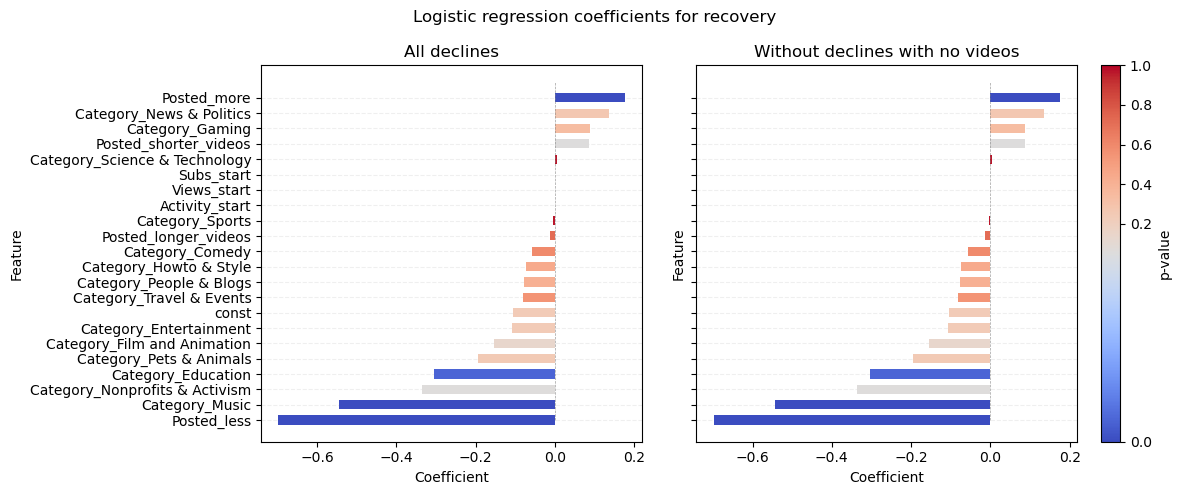

In [41]:
# Columns that are not included in the regression
drop_cols = ['Channel', 'Start', 'End', 'Duration', 'Recovered', 'Mean_duration_difference', 'Mean_frequency_difference']

# Prepare the data for the logistic regression
logit_X = df_sampled.drop(drop_cols, axis=1)
logit_X = pd.get_dummies(logit_X, columns=['Category'], drop_first=True)
logit_y = df_sampled['Recovered']

# Perform the regression
logit_result = perform_logistic_regression(logit_X, logit_y)

# Prepare the data for the logistic regression on the subset
logit_X = df_sampled_without_zero_videos.drop(drop_cols, axis=1)
logit_X = pd.get_dummies(logit_X, columns=['Category'], drop_first=True)
logit_y = df_sampled_without_zero_videos['Recovered']

# Perform the second regression
logit_without_no_videos_result = perform_logistic_regression(logit_X, logit_y)

plot_coeffs_comparison_by_removing_no_videos_declines(logit_result, logit_without_no_videos_result)

As `Posted_more` has a positive impact on recovery, we want to look into what situations benefit the most from posting videos more often.

We therefore look at the characteristics of decline which reacted that way, and when it worked best :

- Did channels who increased publication frequency already post often, or did they post few videos before the
- Is posting more often associated with a lower average video duration?

In [46]:
# Build a new dataframe useful for reaction analysis

df_reactions = pd.concat([df_sampled[['Channel', 'Duration', 'Start', 'End', 'Posted_more', 'Posted_less', 'Posted_longer_videos', 'Posted_shorter_videos', 'Recovered']], df_videos_per_week, df_video_duration], axis=1)

df_reactions['No_change'] = ~df_reactions['Posted_more'] & ~df_reactions['Posted_less']
df_reactions['Frequency_reaction'] = pd.from_dummies(df_reactions[['Posted_more', 'Posted_less', 'No_change']])
df_reactions = df_reactions.drop(['Posted_more', 'Posted_less', 'No_change'], axis=1)

df_reactions['No_change'] = ~df_reactions['Posted_longer_videos'] & ~df_reactions['Posted_shorter_videos']
df_reactions['Video_duration_reaction'] = pd.from_dummies(df_reactions[['Posted_longer_videos', 'Posted_shorter_videos', 'No_change']])
df_reactions = df_reactions.drop(['Posted_longer_videos', 'Posted_shorter_videos', 'No_change'], axis=1)

df_reactions

,Channel,Duration,Start,End,Recovered,Videos_per_week_before,Videos_per_week_after,Mean_duration_before,Mean_duration_after,Frequency_reaction,Video_duration_reaction
0,UC3B6FyoLMLrUYa6i72ccPvw,20,189,209,False,0.950000,0.700000,566.894737,986.642857,No_change,Posted_longer_videos
1,UCIHBFO-XMyTpzXAN-lg8o2g,14,112,126,True,3.357143,2.142857,1095.446809,2527.900000,No_change,Posted_longer_videos
2,UCWmJyyUVP6AoR79IA9MTNpQ,30,192,222,False,0.033333,0.033333,242.000000,235.000000,No_change,No_change
3,UC2MjZanWOfyfsrHOyitmXbQ,14,128,142,True,2.071429,2.500000,721.931034,544.628571,No_change,No_change
4,UCgUtduvq2Wpc7CDHcGDmZog,15,188,203,True,1.600000,1.000000,921.666667,672.133333,No_change,No_change
...,...,...,...,...,...,...,...,...,...,...,...
36591,UC1K0dOUXlTyaDODIxpTBBwQ,17,205,222,False,4.117647,3.235294,711.471429,523.272727,No_change,No_change
36594,UCFc1q8NjbBh_MHJvYP_sbsg,16,224,240,False,1.000000,2.062500,859.937500,630.424242,Posted_more,No_change
36595,UCIPdIlv1EIGyTSfFAfV0Eag,10,236,246,True,0.100000,0.200000,184.000000,144.500000,Posted_more,No_change
36597,UCDmxnPem-pPfJQATIkfgY2Q,41,201,242,False,0.853659,0.634146,2475.542857,2062.692308,No_change,No_change


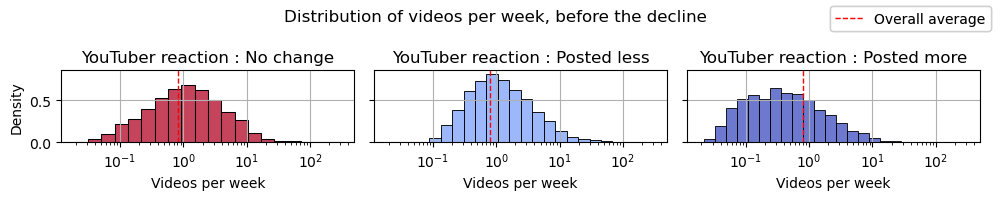

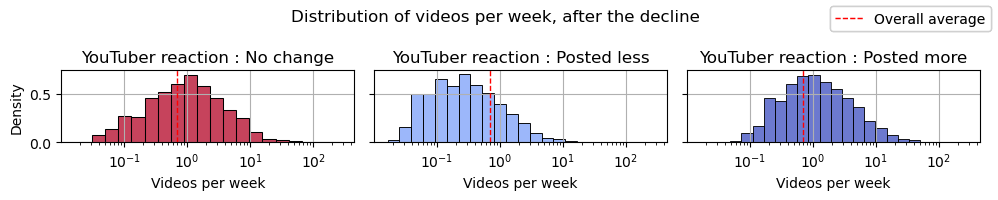

In [47]:
plot_distribution_by_frequency_reaction(df_reactions, 'Videos_per_week_before', 'Distribution of videos per week, before the decline')
plot_distribution_by_frequency_reaction(df_reactions, 'Videos_per_week_after', 'Distribution of videos per week, after the decline')
plt.show()

**Plot description :**

* In red are the channels that during their decline didn't change the frequency of their publications, we plot the ditribution of videos published before and after their decline.

* In light blue are the channels that during they declined decreased the frequency of their publications, we plot the distribution of videos published before and after their decline.

* In dark blue are the channels that during they declined increased the frequency of their publications, we plot the distribution of videos published before and after their decline.

* The red line represents the average number of videos published before/after the decline.

It is interesting to note that the channels that increased video frequency after the start of the decline used to post less than average before the decline, while the ones that reduced video frequency used to post approximately as much as the average. The two groups almost switch places in terms of video frequency.

These observations are good because their decline and recovery can be caused because they posted less videos, and they could have recovered by posting more videos.

### 2. Decision tree

Decision tree accuracy: 0.59


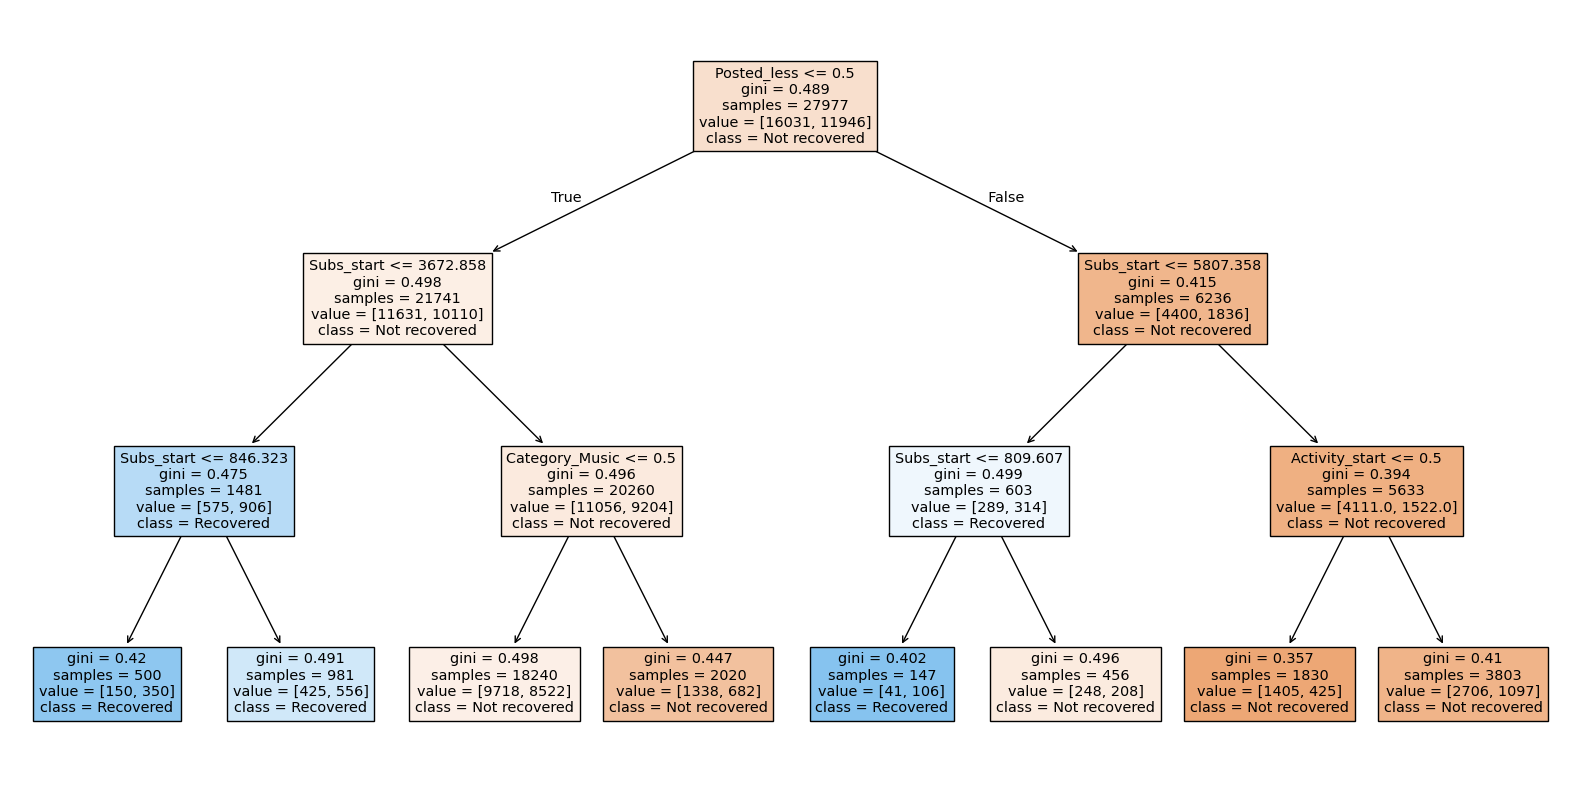

In [ ]:
def perform_decision_tree(X, y):
    # Create the decision tree model
    tree = DecisionTreeClassifier(max_depth=3, random_state=SEED)

    # Evaluate the model using cross-validation
    cv_results = cross_validate(tree, X, y, cv=5, scoring='accuracy')

    # Fit the model on the whole dataset
    tree.fit(X, y)

    return tree, cv_results

tree_X = df_sampled.drop(drop_cols, axis=1)
tree_X = pd.get_dummies(tree_X, columns=['Category'], drop_first=True)

tree_y = df_sampled['Recovered']

tree, cv_results = perform_decision_tree(tree_X, tree_y)

print(f"Decision tree accuracy: {cv_results['test_score'].mean():.2f}")

plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=tree_X.columns, class_names=['Not recovered', 'Recovered'])
plt.show()